# Overvew
- nb009を参考にrenet50を構築してみる

# CONST

In [32]:
NB = '010'
DEBUG = False
PERIOD = 5
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'

In [2]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 50
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 50
    shuffle: True
    num_workers: 5
    pin_memory: True
    drop_last: True
  val:
    batch_size: 50
    shuffle: False
    num_workers: 5
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [3]:
import os
import gc
import cv2 
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torchvision import models
import torch.utils.data as data

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# My function

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

In [5]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [6]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

In [7]:
def get_loaders_for_training(args_dataset, args_loader, train_file_list, val_file_list):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, val_loader

# Preparation

settings

In [8]:
pd.set_option('display.max_columns', 100)

In [9]:
settings = yaml.safe_load(settings_str)
for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 50, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 50, 'shuffle': True, 'num_workers': 5, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 50, 'shuffle': False, 'num_workers': 5, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [10]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [11]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [12]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")
train.head(2).T

,0,1
rating,3.5,4
playback_used,no,no
ebird_code,aldfly,aldfly
channels,1 (mono),2 (stereo)
date,2013-05-25,2013-05-27
pitch,Not specified,both
duration,25,36
filename,XC134874.mp3,XC135454.mp3
speed,Not specified,both
species,Alder Flycatcher,Alder Flycatcher


# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [13]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


<br>

fold

In [14]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [15]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17057, val: 4318


In [48]:
len(train_file_list)+len(valid_file_list)

21375

<br>

train

In [16]:
device = torch.device(settings['globals']['device'])

In [17]:
set_seed(settings['globals']['seed'])

In [18]:
# # # get loader
train_loader, valid_loader = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, valid_file_list)

In [19]:
# resnet50 のファインチューニング
model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(in_features=2048, out_features=len(BIRD_CODE))
model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))
model = model.to(device)

In [20]:
# # # get optimizer
optimizer = getattr(
        torch.optim, settings["optimizer"]["name"]
        )(model.parameters(), **settings["optimizer"]["params"])

# # # get scheduler
scheduler = getattr(
    torch.optim.lr_scheduler, settings["scheduler"]["name"]
    )(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

In [21]:
def train(model, device, train_loader, optimizer, scheduler, loss_func):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_train_loss / len(train_loader.dataset)
                return loss
    loss = epoch_train_loss / len(train_loader.dataset)
    del data
    return loss
        
def get_epoch_loss(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_valid_loss / len(valid_loader.dataset)
                return loss
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

def evaluate(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_valid_loss / len(valid_loader.dataset)
                return loss
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

In [22]:
losses_train = []
losses_valid = []

n_epoch = 3 if DEBUG==True else settings['globals']['num_epochs']
for epoch in progress_bar(range(n_epoch)):
    print(f'\n epoch: {epoch+1} {time.ctime()}')
    loss_train = train(model, device, train_loader, optimizer, scheduler, loss_func)
    loss_valid = get_epoch_loss(model, device, valid_loader, loss_func)
    
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)


 epoch: 1 Tue Aug 11 21:40:51 2020



 epoch: 2 Tue Aug 11 21:53:26 2020



 epoch: 3 Tue Aug 11 22:06:07 2020



 epoch: 4 Tue Aug 11 22:18:47 2020



 epoch: 5 Tue Aug 11 22:31:25 2020



 epoch: 6 Tue Aug 11 22:44:08 2020



 epoch: 7 Tue Aug 11 22:56:46 2020



 epoch: 8 Tue Aug 11 23:09:27 2020



 epoch: 9 Tue Aug 11 23:22:08 2020



 epoch: 10 Tue Aug 11 23:34:48 2020



 epoch: 11 Tue Aug 11 23:47:30 2020



 epoch: 12 Wed Aug 12 00:00:12 2020



 epoch: 13 Wed Aug 12 00:12:54 2020



 epoch: 14 Wed Aug 12 00:25:34 2020



 epoch: 15 Wed Aug 12 00:38:18 2020



 epoch: 16 Wed Aug 12 00:51:00 2020



 epoch: 17 Wed Aug 12 01:03:41 2020



 epoch: 18 Wed Aug 12 01:16:22 2020



 epoch: 19 Wed Aug 12 01:29:04 2020



 epoch: 20 Wed Aug 12 01:41:46 2020



 epoch: 21 Wed Aug 12 01:54:31 2020



 epoch: 22 Wed Aug 12 02:07:14 2020



 epoch: 23 Wed Aug 12 02:19:56 2020



 epoch: 24 Wed Aug 12 02:32:37 2020



 epoch: 25 Wed Aug 12 02:45:20 2020



 epoch: 26 Wed Aug 12 02:58:01 2020



 epoch: 27 Wed Aug 12 03:10:43 2020



 epoch: 28 Wed Aug 12 03:23:26 2020



 epoch: 29 Wed Aug 12 03:36:06 2020



 epoch: 30 Wed Aug 12 03:48:45 2020



 epoch: 31 Wed Aug 12 04:01:27 2020



 epoch: 32 Wed Aug 12 04:14:08 2020



 epoch: 33 Wed Aug 12 04:26:49 2020



 epoch: 34 Wed Aug 12 04:39:30 2020



 epoch: 35 Wed Aug 12 04:52:13 2020



 epoch: 36 Wed Aug 12 05:04:54 2020



 epoch: 37 Wed Aug 12 05:17:37 2020



 epoch: 38 Wed Aug 12 05:30:19 2020



 epoch: 39 Wed Aug 12 05:43:02 2020



 epoch: 40 Wed Aug 12 05:55:42 2020



 epoch: 41 Wed Aug 12 06:08:23 2020



 epoch: 42 Wed Aug 12 06:21:04 2020



 epoch: 43 Wed Aug 12 06:33:47 2020



 epoch: 44 Wed Aug 12 06:46:29 2020



 epoch: 45 Wed Aug 12 06:59:13 2020



 epoch: 46 Wed Aug 12 07:11:56 2020



 epoch: 47 Wed Aug 12 07:24:38 2020



 epoch: 48 Wed Aug 12 07:37:20 2020



 epoch: 49 Wed Aug 12 07:50:02 2020



 epoch: 50 Wed Aug 12 08:02:43 2020


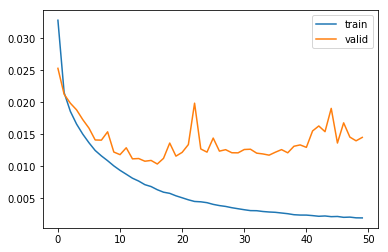

In [23]:
plt.plot(losses_train, label='train')
plt.plot(losses_valid, label='valid')
plt.legend()

In [24]:
del train_loader
# del valid_loader
# del model
del optimizer
del scheduler
del loss_func

gc.collect()

8

# save model

In [39]:
save_dir = f'{DIR_MODEL}/nb{NB}_{model.__class__.__name__}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [40]:
save_path = f'{save_dir}model_{model.__class__.__name__}.pth'
save_path

'./../data_ignore/model/nb010_ResNet/model_ResNet.pth'

In [41]:
torch.save(model.state_dict(), save_path)

# check model

In [45]:
load_weights = torch.load(save_path)
model.load_state_dict(load_weights)

<All keys matched successfully>